# Mumbai House Price Prediction Model

This notebook demonstrates how to build a house price prediction model for Mumbai using the provided dataset. We will perform data preprocessing, explore correlations, visualize data, and train a LightGBM Regressor model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Note: LightGBM is used for the model, you might need to install it:
# pip install lightgbm
import lightgbm as lgb

# Load the dataset
df = pd.read_csv('Mumbai House Prices.csv')
df_original = df.copy()
print("Original DataFrame Info:")
df.info()
print("\nOriginal DataFrame Head:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bhk         76038 non-null  int64  
 1   type        76038 non-null  object 
 2   locality    76038 non-null  object 
 3   area        76038 non-null  int64  
 4   price       76038 non-null  float64
 5   price_unit  76038 non-null  object 
 6   region      76038 non-null  object 
 7   status      76038 non-null  object 
 8   age         76038 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 5.2+ MB

Original DataFrame Head:
| bhk   | type      | locality                             | area   | price   | price_unit   | region         | status             | age   |
|:------|:----------|:-------------------------------------|:-------|:--------|:-------------|:---------------|:-------------------|:------|
| 3     | Apartment | Lak And Hanware The Resi

## Data Preprocessing
1. **Convert Price to Lakhs**: The `price` column has units 'Cr' (Crore) and 'L' (Lakh). We convert all prices to Lakhs for consistency. (1 Crore = 100 Lakhs).
2. **Drop Original Price Columns**: Remove the original `price` and `price_unit` columns.

In [3]:
# Convert price to Lakhs
def convert_price_to_lakhs(row):
    if row['price_unit'] == 'Cr':
        return row['price'] * 100
    else:
        return row['price']

df['price_lakhs'] = df.apply(convert_price_to_lakhs, axis=1)

# Drop original price and price_unit columns
df_processed = df.drop(columns=['price', 'price_unit'])

print("Processed DataFrame Head with Price in Lakhs:")
print(df_processed.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nProcessed DataFrame Info:")
df_processed.info()

Processed DataFrame Head with Price in Lakhs:
| bhk   | type      | locality                             | area   | region         | status             | age   | price_lakhs   |
|:------|:----------|:-------------------------------------|:-------|:---------------|:-------------------|:------|:--------------|
| 3     | Apartment | Lak And Hanware The Residency Tower  | 685    | Andheri West   | Ready to move      | New   | 250           |
| 2     | Apartment | Radheya Sai Enclave Building No 2    | 640    | Naigaon East   | Under Construction | New   | 52.51         |
| 2     | Apartment | Romell Serene                        | 610    | Borivali West  | Under Construction | New   | 173           |
| 2     | Apartment | Soundlines Codename Urban Rainforest | 876    | Panvel         | Under Construction | New   | 59.98         |
| 2     | Apartment | Origin Oriana                        | 659    | Mira Road East | Under Construction | New   | 94.11         |

Processed DataFrame Info:
<cl

## Correlation Analysis
We will analyze the correlation between numerical features and the target variable (`price_lakhs`). For categorical features, we'll examine their relationship with the target using group-by operations and visualizations.


Correlation Matrix for Numerical Features:
|             |      bhk |     area |   price_lakhs |
|:------------|---------:|---------:|--------------:|
| bhk         | 1        | 0.787738 |      0.631353 |
| area        | 0.787738 | 1        |      0.756    |
| price_lakhs | 0.631353 | 0.756    |      1        |


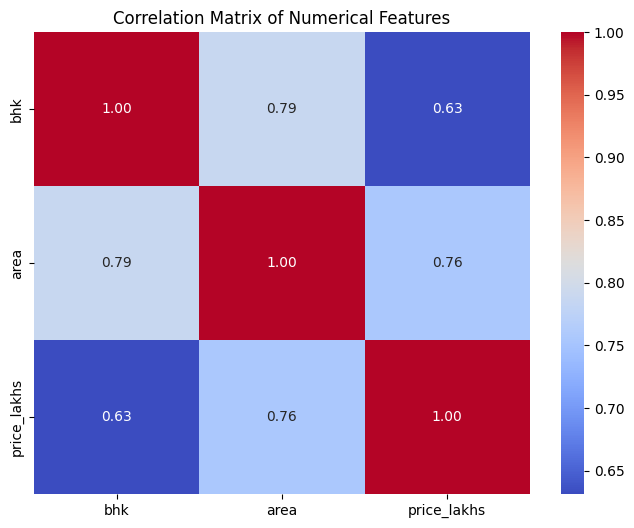


Mean Price by Categorical Features:

type vs Price:
| type              |   price_lakhs |
|:------------------|--------------:|
| Villa             |       733.365 |
| Independent House |       422.077 |
| Penthouse         |       300     |
| Apartment         |       168.004 |
| Studio Apartment  |        37.305 |

region vs Price:
| region                  |   price_lakhs |
|:------------------------|--------------:|
| Malabar Hill            |     2750      |
| Peddar Road             |     2062.5    |
| Napeansea Road          |     1770      |
| Babulnath Road          |     1426.67   |
| Worli                   |     1072.35   |
| Bandra                  |     1060      |
| Juhu                    |     1026.5    |
| Tardeo                  |      960.739  |
| Prabhadevi              |      949.811  |
| Churchgate              |      825      |
| Lower Parel             |      813.947  |
| Bandra West             |      790.105  |
| Mahalaxmi               |      750.646  |
| S

In [5]:
print("\nCorrelation Matrix for Numerical Features:")
print(df_processed[['bhk', 'area', 'price_lakhs']].corr().to_markdown())

plt.figure(figsize=(8, 6))
sns.heatmap(df_processed[['bhk', 'area', 'price_lakhs']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("\nMean Price by Categorical Features:")
for col in ['type', 'region', 'status', 'age']:
    print(f"\n{col} vs Price:")
    print(df_processed.groupby(col)['price_lakhs'].mean().sort_values(ascending=False).to_markdown())

## Data Visualization
Visualizations help us understand the distribution of data and relationships between variables.

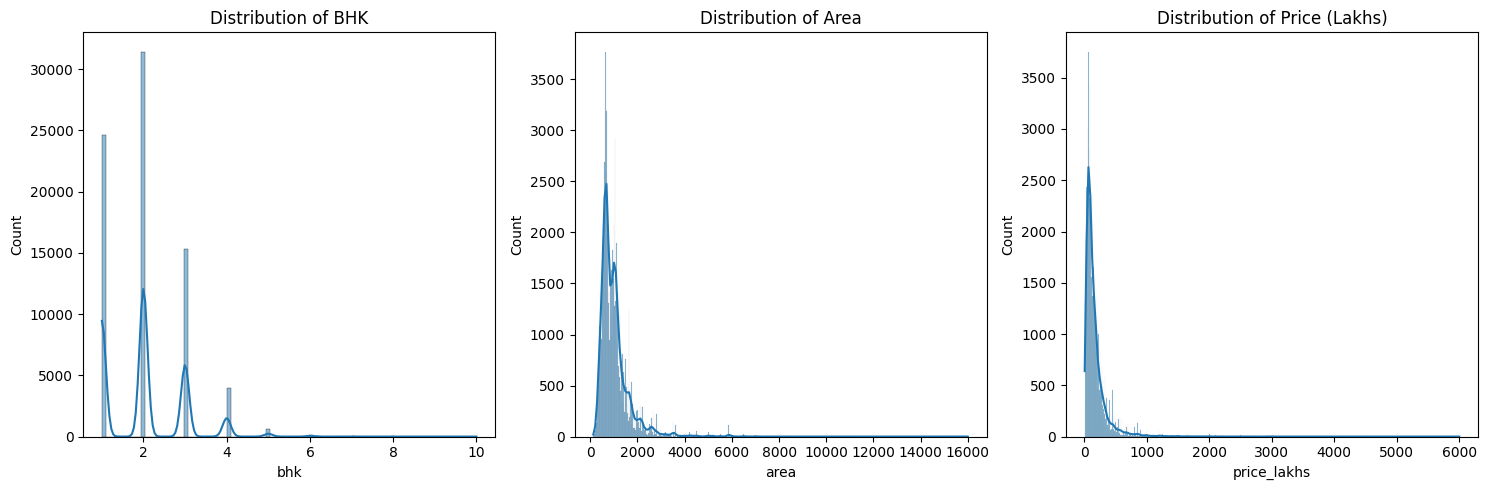

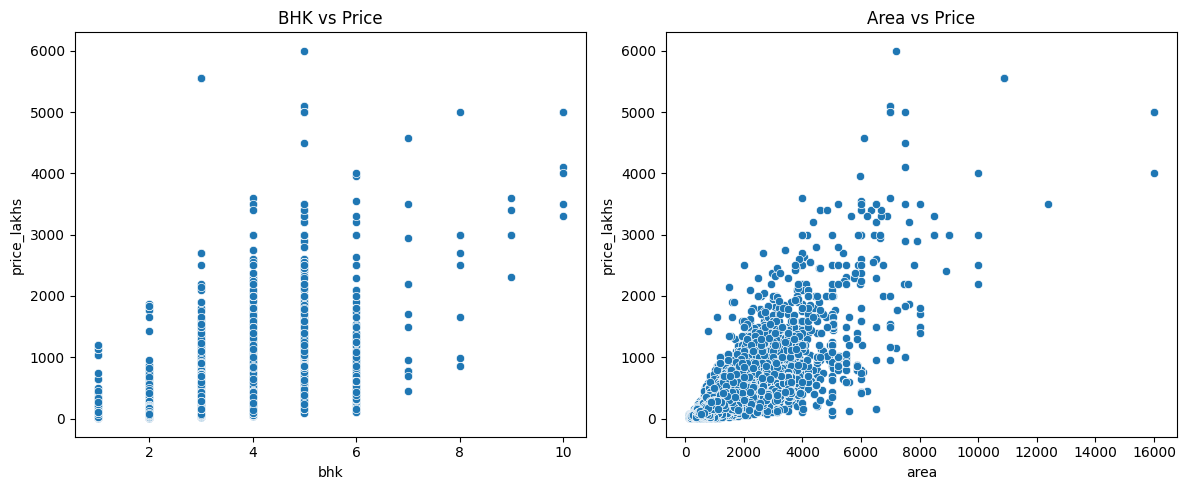

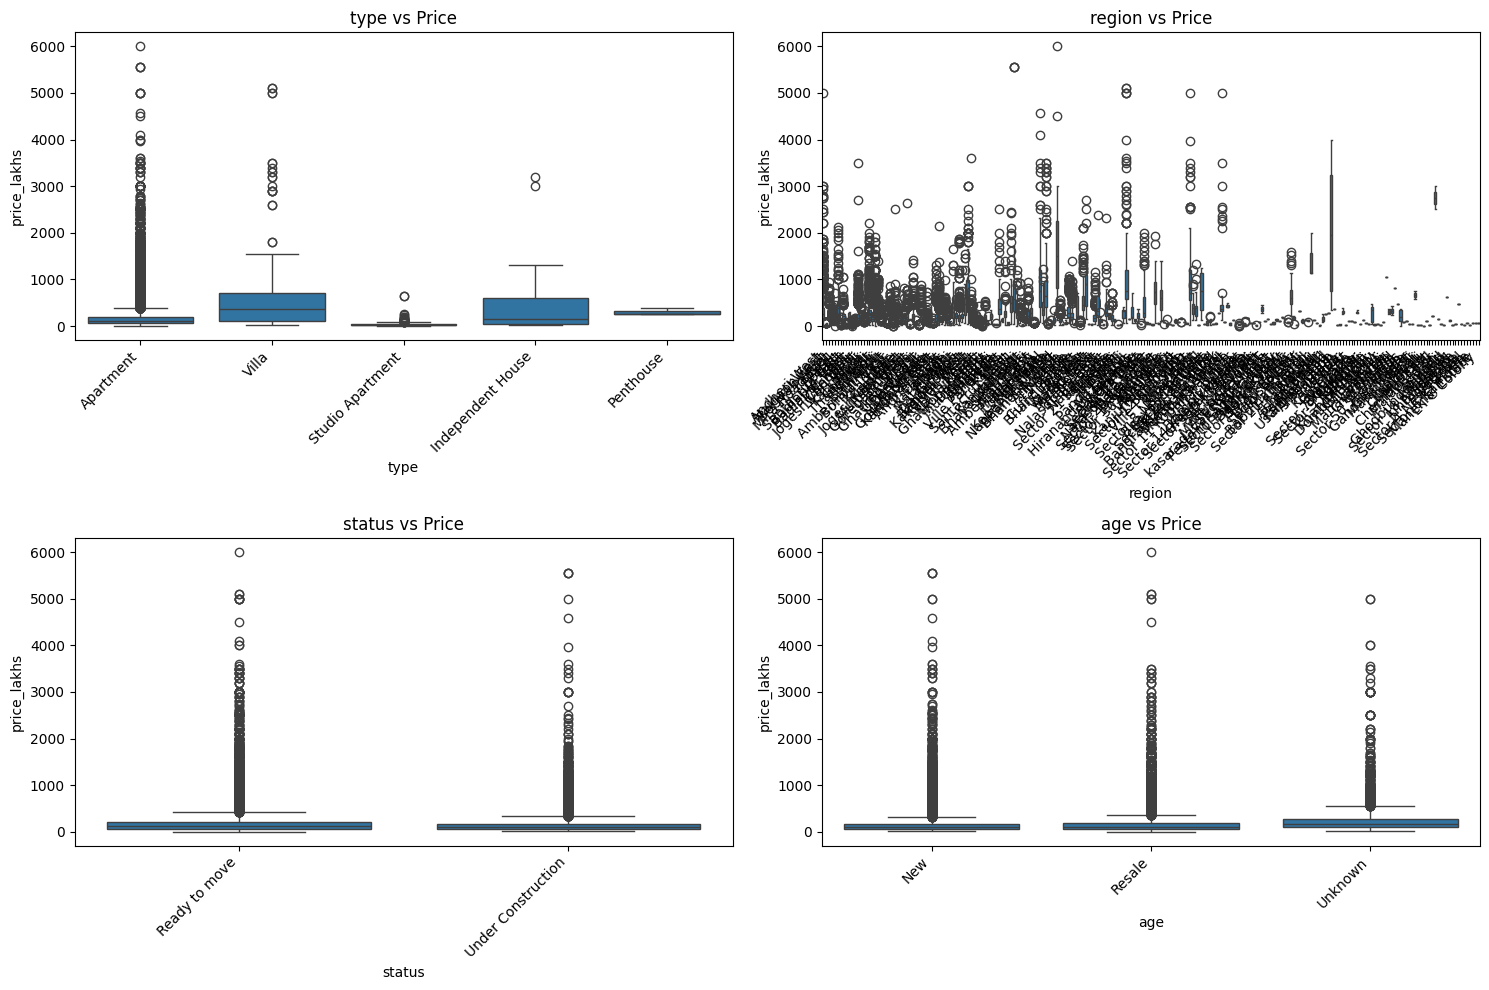

In [6]:
# Distribution of numerical features
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df_processed['bhk'], kde=True)
plt.title('Distribution of BHK')
plt.subplot(1, 3, 2)
sns.histplot(df_processed['area'], kde=True)
plt.title('Distribution of Area')
plt.subplot(1, 3, 3)
sns.histplot(df_processed['price_lakhs'], kde=True)
plt.title('Distribution of Price (Lakhs)')
plt.tight_layout()
plt.show()

# Scatter plots of numerical features vs price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='bhk', y='price_lakhs', data=df_processed)
plt.title('BHK vs Price')
plt.subplot(1, 2, 2)
sns.scatterplot(x='area', y='price_lakhs', data=df_processed)
plt.title('Area vs Price')
plt.tight_layout()
plt.show()

# Box plots for categorical features vs price
categorical_for_plot = ['type', 'region', 'status', 'age']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_for_plot):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=col, y='price_lakhs', data=df_processed)
    plt.title(f'{col} vs Price')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Feature Engineering and Data Splitting
We define our features (X) and target (y), and then split the data into training and testing sets to evaluate model performance on unseen data. We also apply one-hot encoding to categorical features.

In [7]:
# Define categorical and numerical features for the model
categorical_features_model = ['type', 'locality', 'region', 'status', 'age']
numerical_features_model = ['bhk', 'area']

# Create a column transformer for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features_model),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_model)
    ])

# Define features (X) and target (y)
X = df_processed.drop('price_lakhs', axis=1)
y = df_processed['price_lakhs']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60830, 7)
y_train shape: (60830,)
X_test shape: (15208, 7)
y_test shape: (15208,)


## Model Training with Hyperparameter Tuning and Evaluation
We use a LightGBM Regressor for its efficiency and accuracy. To improve accuracy, we perform hyperparameter tuning using `GridSearchCV` with cross-validation. The model is trained on the training data and evaluated on the test data using metrics such as R-squared, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

In [8]:
# Create a pipeline with preprocessing and LightGBM Regressor
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', lgb.LGBMRegressor(random_state=42))])

# Define parameter grid for GridSearchCV (example parameters - can be expanded)
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__num_leaves': [20, 31, 40]
}

# Perform GridSearchCV for hyperparameter tuning with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R-squared score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5

print(f"\nModel Evaluation on Test Set (with best parameters):")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 60830, number of used features: 733
[LightGBM] [Info] Start training from score 168.578161
Best parameters found: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 300, 'regressor__num_leaves': 31}
Best R-squared score: 0.8625

Model Evaluation on Test Set (with best parameters):
R-squared: 0.8953
Mean Absolute Error: 27.13
Mean Squared Error: 4783.63
Root Mean Squared Error: 69.16


C:\Users\manov\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Conclusion
This notebook provides a comprehensive approach to predicting Mumbai house prices, including data exploration, visualization, correlation analysis, and a tuned LightGBM regression model. The evaluation metrics indicate the model's performance on unseen data. Further improvements could involve more advanced feature engineering, exploring other models, or collecting more data.